In [1]:
import numpy as np
from mayavi import mlab
import trimesh

from bfieldtools.coil_optimize import optimize_streamfunctions
from bfieldtools.mesh_conductor import MeshConductor

from bfieldtools.viz import plot_data_on_vertices
from bfieldtools import sphtools

In [2]:
mlab.init_notebook('png')

Notebook initialized with png backend.


In [4]:
error_radius = 25

Rz = trimesh.transformations.rotation_matrix(np.pi/2., [0, 0, 1])
Ry = trimesh.transformations.rotation_matrix(np.pi/2., [1, 0, 0])
coil_mesh = trimesh.load("meshes/cylinder_42mm.stl")
# coil_mesh.apply_transform(Rz)
# coil_mesh.apply_transform(Ry)
coil = MeshConductor(
    mesh_obj=coil_mesh, 
    fix_normals=True,
    basis_name='suh', 
    N_suh=250, #100
    sph_radius=error_radius,#20
    sph_normalization="energy",
    )


Calculating surface harmonics expansion...
Computing the laplacian matrix...
Computing the mass matrix...


In [6]:
n = 10
y = np.reshape(np.linspace(-error_radius, error_radius, n), (1, n))
x = np.zeros((1, n))
z = np.zeros((1, n))

trgt_pts = np.concatenate((x.T, y.T, z.T), axis = 1)


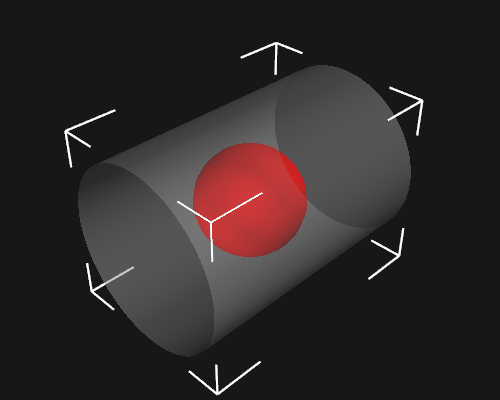

In [8]:
f = mlab.figure(bgcolor=(23./255, 23./255, 23./255), fgcolor=(.5, .5, .5), size=(500, 400))
mlab.points3d([0], [0], [0], scale_factor=error_radius*2, scale_mode='none', resolution=20, color=(1, 0, 0), opacity=0.8)

# mlab.points3d(*trgt_pts.T, color=(0,1,0))
coil.plot_mesh(opacity=0.5, figure=f, )
ol = mlab.outline(color=(1, 1, 1), line_width=1.5)
# mlab.yaw(10)
# axes = mlab.axes(color=(0, 0, 0))
# axes.label_text_property.font_size=10
ol.outline_mode='cornered'

# cam = cam+np.array([0, 0.1, 0])
# mlab.gcf().scene.parallel_projection = True
# mlab.view(0, 90)
mlab.savefig("domain_front.png", figure=f, size=(500, 400))
f


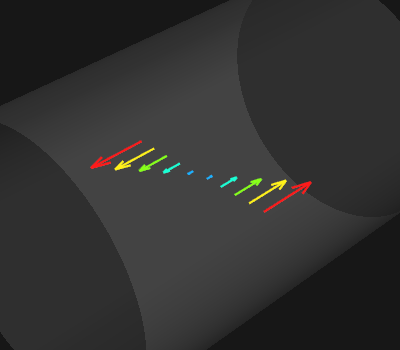

In [9]:

# trgt_pts
alm = np.zeros((coil.opts["N_sph"]* (coil.opts["N_sph"]+2),))
blm = np.zeros((coil.opts["N_sph"]* (coil.opts["N_sph"]+2),))


blm[7] += 1


sphfield = sphtools.field(trgt_pts, alm, blm, coil.opts["N_sph"])
target_field = sphfield / np.max(sphfield[:, 0])

field_y = target_field.copy()

field_y[:, 2] = 0
field_y[:, 1] = 0

field_y
mlab.clf()
f = mlab.figure(bgcolor=(23./255, 23./255, 23./255), fgcolor=(1, 1, 1))
mlab.quiver3d(*trgt_pts.T, *field_y.T, figure=f, line_width=2, scale_factor=20)
coil.plot_mesh(opacity=0.1, figure=f)
# f.scene.isometric_view()
f.scene.camera.zoom(1.7)

# mlab.view(90, 180)
f

In [10]:
import mosek

target_spec = {
    "coupling": coil.sph_couplings[1],
    "abs_error": 0.001, # 0.01
    "target": blm,
}

Computing coupling matrices
l = 1 computed
l = 2 computed
l = 3 computed
l = 4 computed
l = 5 computed


In [11]:
coil.s, prob = optimize_streamfunctions(
    coil,
    [target_spec],
    objective="minimum_inductive_energy",
    solver="MOSEK",
    solver_opts={"mosek_params": {mosek.iparam.num_threads: 4}},
)

Computing the inductance matrix...
Computing self-inductance matrix using rough quadrature (degree=2).              For higher accuracy, set quad_degree to 4 or more.
Estimating 56299 MiB required for 4200 by 4200 vertices...
Computing inductance matrix in 1600 chunks (712 MiB memory free),              when approx_far=True using more chunks is faster...
Computing triangle-coupling matrix
Inductance matrix computation took 196.35 seconds.
Passing problem to solver...
                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) May 12 03:38:54 PM: Your problem has 250 variables, 2 constraints, and 0 parameters.
(CVXPY) May 12 03:38:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 03:38:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 12 03:38:54 PM: CVXPY will first compile your pr

Processing contour, value: -719.9908247386161
Processing contour, value: -623.9917264192027
Processing contour, value: -527.9926280997893
Processing contour, value: -431.99352978037575
Processing contour, value: -335.99443146096235
Processing contour, value: -239.99533314154894
Processing contour, value: -143.99623482213542
Processing contour, value: -47.997136502722014
Processing contour, value: 48.00196181669139
Processing contour, value: 144.0010601361048
Processing contour, value: 240.00015845551832
Processing contour, value: 335.9992567749316
Processing contour, value: 431.99835509434524
Processing contour, value: 527.9974534137586
Processing contour, value: 623.996551733172
Processing contour, value: 719.9956500525855



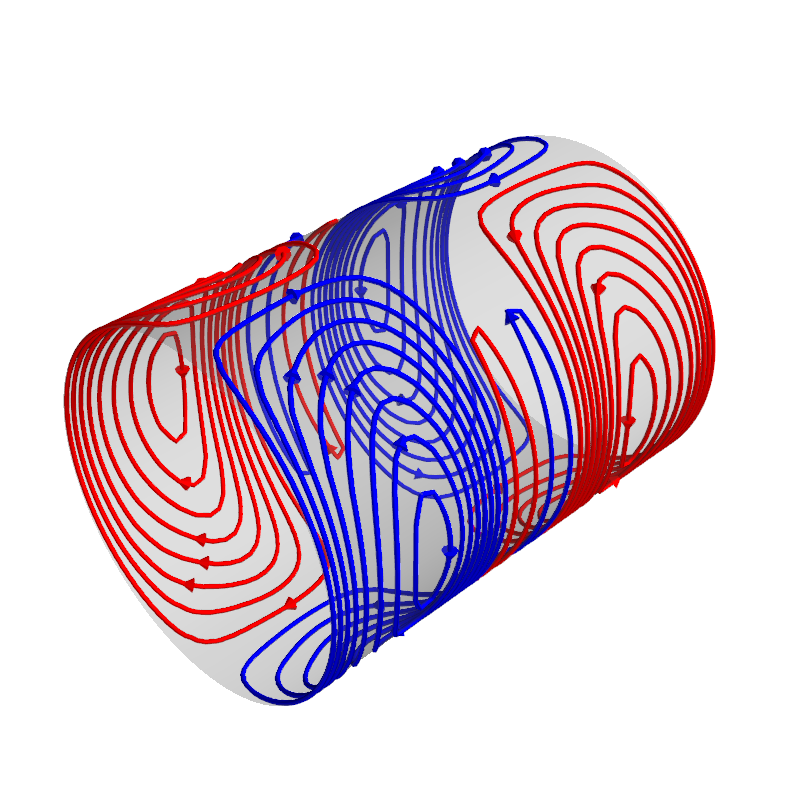

In [13]:
f = coil.plot_mesh(opacity=0.3)

loops = coil.s.discretize(N_contours=16)
loops.plot_loops(figure=f)

In [14]:
loops_dict = loops.to_dict()


paths = loops_dict['entities']
verts = loops_dict['vertices']

vertices = []


for v in verts: # X axis cilynder
    x, y, z = v
    vertices.append((x, y, z))

path = []
for p in paths:
    line = p['points']
    for i in range(len(line)):
        if i == len(line)-1:
            path.append((line[i], line[0]))
        else:
            path.append((line[i], line[i+1]))

In [15]:
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.interpolate import splprep, splev


col = plt.cm.viridis(np.linspace(0, 1, int(len(paths)/4)))

def spline_length(spl, closed=False):
    u = np.linspace(0, 1, 100)
    I = 0
    add_cl = 0 if closed else 0
    for i in range(len(u)-add_cl):
        if closed and i == len(u)-1:
            I += np.linalg.norm(np.array(splev(u[i], spl)) - np.array(splev(u[0], spl)))
        else:
            I += np.linalg.norm(np.array(splev(u[i+1], spl)) - np.array(splev(u[i], spl)))
    
    return I

    
L = []
for j in range(len(paths)):
    line = np.array([list(vertices[i]) for i in paths[j]['points']])
    # plt.plot(*line.T, alpha=0.3, color='k')
    L.append(line)



## Refactor contours with equally spaced points

In [16]:
new_vertices = []
new_edges = []
tot_len = 0
index = 0

res = 0.9
closed = True
for line in L: #tl+tr+br+bl
    spl, _ = splprep(line.T, s=0)
    l = spline_length(spl, True)
    tot_len+=l
    points = np.linspace(0, 1, int(l/res))

    for i, p in enumerate(points):
        
        vert = tuple(list(np.array(splev(p, spl))))
        new_vertices.append(vert)
        
        if i > 0:
            new_edges.append((index-1, index))
        index+=1

# print(line)
print(new_edges[-1])
print(tot_len)
plt.show()

(7727, 7728)
6974.681307511196


# For blender

In [17]:
# new_vertices = np.array(new_vertices)
# new_edges = np.array(new_edges, dtype=np.int32)

# with open('vertices_closed_3.txt', 'w') as f:
#    np.savetxt(f, new_vertices)

# with open('edges_closed_3.txt', 'w') as f:
#    np.savetxt(f, new_edges)

### Path by path export

In [19]:
tot_len = 0
index = 0

res = 1
closed = True
for j, line in enumerate(L): #tl+tr+br+bl
    verts = []
    spl, _ = splprep(line.T, s=0)
    l = spline_length(spl, True)
    tot_len+=l
    points = np.linspace(0, 1, int(l/res))

    for i, p in enumerate(points):
        
        vert = tuple(list(np.array(splev(p, spl))))
        verts.append(vert)
        
    np.savetxt(f"paths_cyl/{j}.txt", verts)
    